# Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
from cv2 import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

2025-07-18 07:07:58.513152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752822478.535010    3349 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752822478.541685    3349 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Preparation

In [2]:
path = '/kaggle/input/solar-panel-images/Faulty_solar_panel'

In [3]:
img_height = 244
img_width = 244

train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset = 'training',
    image_size = (img_height, img_width),
    batch_size = 32,
    seed = 42,
    shuffle = True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size = 32,
    seed = 42,
    shuffle = True
)

Found 885 files belonging to 6 classes.
Using 708 files for training.


I0000 00:00:1752822481.622929    3349 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752822481.623712    3349 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['Bird-drop',
 'Clean',
 'Dusty',
 'Electrical-damage',
 'Physical-Damage',
 'Snow-Covered']

# Visualize the Dataset

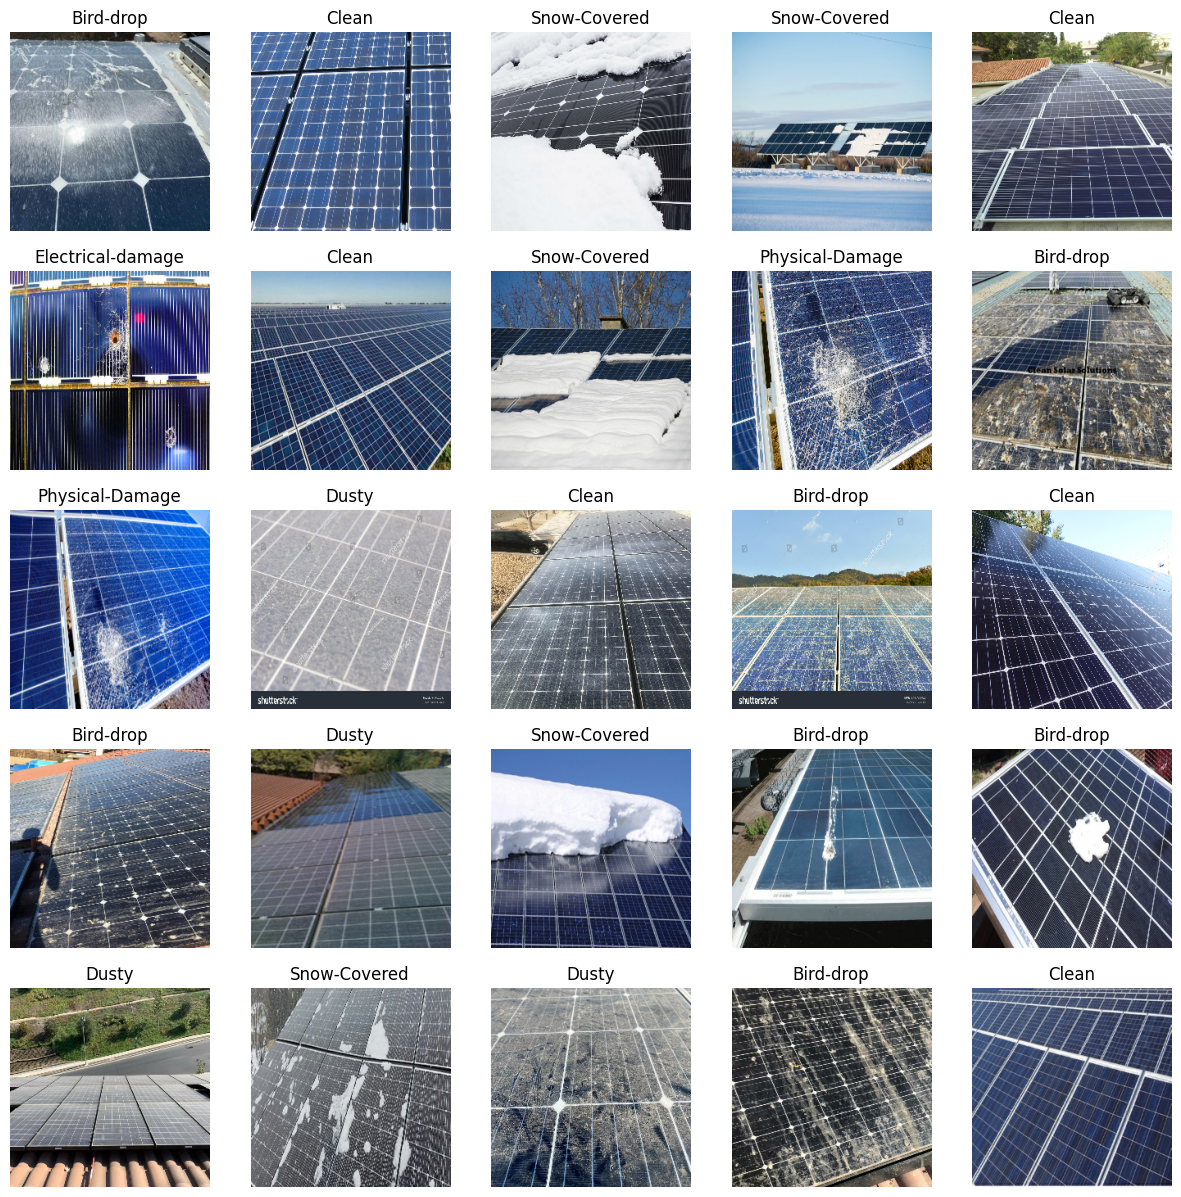

In [5]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
base_model.trainable = False

In [7]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax') 
])

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,198 (90.06 MB)

 Trainable params: 16,390 (64.02 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


I0000 00:00:1752822496.724140    3405 service.cc:148] XLA service 0x7b318c002750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752822496.724179    3405 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752822496.724182    3405 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752822498.413650    3405 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.1328 - loss: 3.4829 

I0000 00:00:1752822503.185029    3405 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 746ms/step - accuracy: 0.2642 - loss: 2.5384 - val_accuracy: 0.5141 - val_loss: 1.2832 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5922 - loss: 1.2386 - val_accuracy: 0.6610 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.6788 - loss: 0.9376 - val_accuracy: 0.7232 - val_loss: 0.8087 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.7692 - loss: 0.7188 - val_accuracy: 0.7627 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7990 - loss: 0.5958 - val_accuracy: 0.7910 - val_loss: 0.6331 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.8200 - loss: 0.5371 - val_accuracy: 0.8079 - val_loss: 0.5815 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8487 - loss: 0.4293 - val_accura

# Model Evaluation

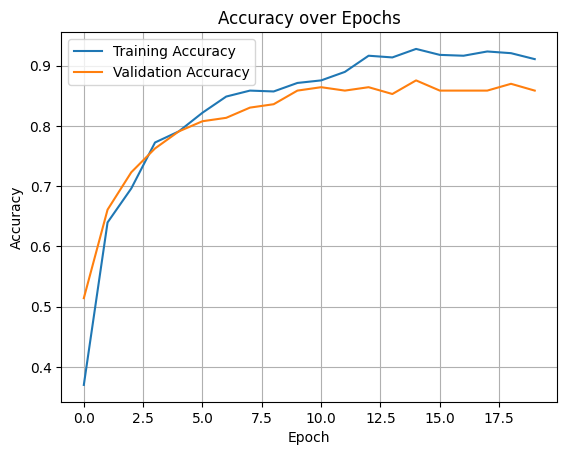

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

In [14]:
true_labels = []
predicted_labels = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)

    predicted_labels.extend(preds.numpy())
    true_labels.extend(labels.numpy())

print(classification_report(true_labels, predicted_labels, digits=4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0     0.8431    0.9556    0.8958        45
           1     0.7895    0.8824    0.8333        34
           2     0.9118    0.7209    0.8052        43
           3     0.9286    0.8125    0.8667        16
           4     1.0000    0.9474    0.9730        19
           5     0.9091    1.0000    0.9524        20

    accuracy                         0.8757       177
   macro avg     0.8970    0.8865    0.8877       177
weighted avg     0.8815    0.8757    0.8738       177



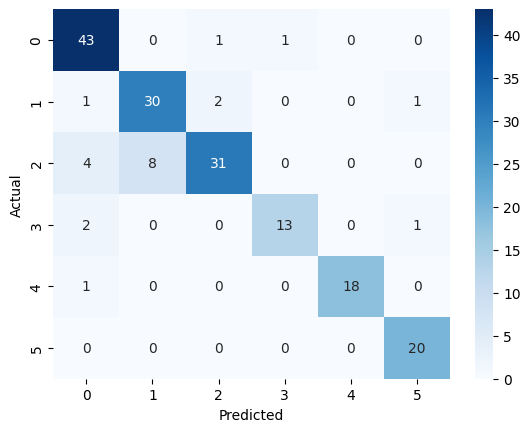

In [15]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()